# Visualize dataset

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from omegaconf import OmegaConf

import event_prediction
from event_prediction.data.data_utils import download_data_from_url
import openpyxl

In [2]:

url = "https://obj.umiacs.umd.edu/eventprediction/transactions_small.tgz"  # 1k transactions
# url = "https://obj.umiacs.umd.edu/eventprediction/transactions_med.tgz"  # 1m transactions
# url = "https://obj.umiacs.umd.edu/eventprediction/transactions.tgz"  # 25m transactions
data = download_data_from_url(url)
print("Extracting...")
data = extract(data)
print("Creating dataframe...")
df = pd.read_csv(data)

print(f"Total rows: {df.shape[0]}, total columns: {df.shape[1]}")
df.head()

Extracting...
Creating dataframe...
Total rows: 1000, total columns: 16


,Unnamed: 0,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


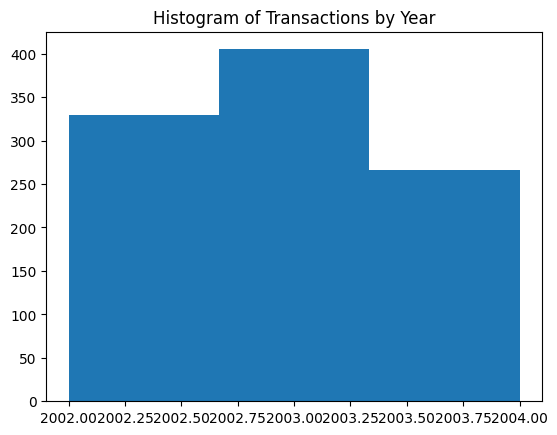

In [10]:
plt.hist(df['Year'], bins=len(df['Year'].unique()))
plt.title('Histogram of Transactions by Year')
plt.show()

In [3]:
cfg_dir = "event_prediction/config"
cfg = OmegaConf.load(f"{cfg_dir}/pre_process_data.yaml")
data_cfg = OmegaConf.load(f"{cfg_dir}/data/ibm_fraud_transaction_small.yaml")
token_cfg = OmegaConf.load(f"{cfg_dir}/tokenizer/composite.yaml")

tokenizer = event_prediction.get_tokenizer(token_cfg, data_cfg)

In [4]:

normed_data = tokenizer.normalize(df)
normed_data.head()

,User,Card,Use Chip,Merchant State,MCC,Errors?,top_mcc,top_chip,Amount,Hour,total_minutes_from_last,Is Fraud?,is_online,avg_dollar_amt,std_dollar_amt
0,0,0,SwipeTransaction,CA,5300,<NA>,5411,SwipeTransaction,8,0,0,True,False,5,5
1,0,0,SwipeTransaction,CA,5411,<NA>,5411,SwipeTransaction,2,0,1,True,False,5,5
2,0,0,SwipeTransaction,CA,5411,<NA>,5411,SwipeTransaction,7,0,7,True,False,5,5
3,0,0,SwipeTransaction,CA,5651,<NA>,5411,SwipeTransaction,8,5,5,True,False,5,5
4,0,0,SwipeTransaction,CA,5912,<NA>,5411,SwipeTransaction,7,0,5,True,False,5,5


In [5]:
wordified_data, labels = tokenizer.pretokenize(normed_data)
wordified_data.head()

0    SwipeTransaction_CA_5300_<NA>_5411_SwipeTransa...
1    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
2    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
3    SwipeTransaction_CA_5651_<NA>_5411_SwipeTransa...
4    SwipeTransaction_CA_5912_<NA>_5411_SwipeTransa...
dtype: object

In [6]:
tokenized_data = tokenizer.model(wordified_data)
tokenized_data.head()

0    SwipeTransaction_CA_5300_<NA>_5411_SwipeTransa...
1    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
2    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
3    SwipeTransaction_CA_5651_<NA>_5411_SwipeTransa...
4    SwipeTransaction_CA_5912_<NA>_5411_SwipeTransa...
dtype: object

In [7]:
post_processed_data = tokenizer.post_process(tokenized_data, labels)
post_processed_data[:5]

['User',
 'Card',
 'SwipeTransaction_CA_5300_<NA>_5411_SwipeTransaction_8_0_0_True_False_5_5',
 'SwipeTransaction_CA_5411_<NA>_5411_SwipeTransaction_2_0_1_True_False_5_5',
 'SwipeTransaction_CA_5411_<NA>_5411_SwipeTransaction_7_0_7_True_False_5_5']

In [14]:
# Optionally save a subset of the dataset if you wish.

# subset_size = 1e6
# df.head(int(subset_size)).to_csv('temp.csv', index=False)
# with tarfile.open('transactions_med.tgz', 'w:gz') as f:
#     f.add('temp.csv')

In [18]:
import pandas as pd


path = "/Users/alex/Documents/School/Maryland/Research/event_prediction/data/submit/raw.csv"
df = pd.read_csv(path)

# Convert unixReviewTime to human-readable format
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

# Mapping column names
column_mapping = {
    'reviewerID': 'User',
    'unixReviewTime': 'Time',
    'overall': 'Rating',
    'verified': 'Verified'
}

# Rename the columns
df.rename(columns=column_mapping, inplace=True)

# Convert Time to only include HH:MM:SS
# df['Time'] = df['Time'].dt.strftime('%H:%M:%S')
# df['Time'] = df['Time'].dt.strftime('%d/%m/%Y')

import random
# Generate random times
random_times = [f'{random.randint(0, 23):02}:{random.randint(0, 59):02}:{random.randint(0, 59):02}' for _ in range(len(df))]

# Replace the Time column with random times
df['Time'] = random_times

# Truncate ASIN and User IDs to the last 5 characters
df['User'] = df['User'].apply(lambda x: x[-5:])
df['asin'] = df['asin'].apply(lambda x: x[-5:])

# Replace True/False with T/F
df['Verified'] = df['Verified'].apply(lambda x: 'T' if x else 'F')

# Sort the DataFrame by 'User' and 'Time'
df_sorted = df.sort_values(by=['User', 'Time'])

# Group the data by 'User'
grouped = df_sorted.groupby('User')


In [22]:
# Select the first 5 sequences
raw_25 = df_sorted.head(25)

# Display the first 5 sequences
print(raw_25)

# Save the reshaped DataFrame as a CSV file
# reshaped_df_first_5_sequences.to_csv('formatted_sequences.csv')

# Save the reshaped DataFrame as an Excel file
raw_25.to_excel('raw_25.xlsx', index=True)


      User      Time   asin Verified  Rating
343  04DPR  06:33:12  89003        T       5
344  04DPR  07:56:57  PHDCE        T       5
345  04DPR  16:43:36  W3HA0        T       5
346  04DPR  17:40:19  3B9US        T       5
342  04DPR  20:47:33  WEQ7G        T       5
159  07PY4  01:30:30  ZPQX8        T       4
158  07PY4  02:47:15  44371        T       4
157  07PY4  03:29:16  1RDVQ        T       3
154  07PY4  07:14:11  G97Z6        T       5
160  07PY4  10:59:07  58202        T       5
161  07PY4  11:56:50  RYN5Y        T       4
155  07PY4  15:41:09  PZ03O        T       4
156  07PY4  16:47:49  GZK6I        T       3
162  07PY4  21:10:29  91701        T       4
270  0PVBG  05:25:04  09514        T       5
269  0PVBG  09:58:37  7QCGS        T       5
271  0PVBG  11:16:25  9GDQ4        T       5
268  0PVBG  15:33:38  L7C82        T       5
272  0PVBG  16:50:48  6NGT4        T       5
274  141XY  03:56:51  JVHCM        T       5
273  141XY  06:55:16  5N1ZO        T       5
278  141XY

In [19]:

# Function to split events into sequences of 5 events each and format them
def split_and_format_sequences(user_df, n_events=5):
    sequences = []
    for i in range(0, len(user_df), n_events):
        seq = user_df.iloc[i:i+n_events]
        if len(seq) == n_events:
            sequences.append(seq.values.flatten())
    return sequences

# Apply the function to each group and create a new DataFrame
all_sequences = []
user_indices = []
for name, group in grouped:
    user_sequences = split_and_format_sequences(group)
    all_sequences.extend(user_sequences)
    user_indices.extend([name] * len(user_sequences))

# Determine the number of events and features dynamically
num_features_per_event = 5  # User, Time, Asin, Verified, Rating
num_events = len(all_sequences[0]) // num_features_per_event

# Create multi-level column names
columns = []
for i in range(1, num_events // num_features_per_event + 1):
    columns.extend([(f'Event {i}', 'User'), (f'Event {i}', 'Time'), (f'Event {i}', 'Asin'), (f'Event {i}', 'Verified'), (f'Event {i}', 'Rating')])

# Adjust columns to match the actual data length
if len(all_sequences[0]) != len(columns):
    num_events = len(all_sequences[0]) // num_features_per_event
    columns = []
    for i in range(1, num_events + 1):
        columns.extend([(f'Event {i}', 'User'), (f'Event {i}', 'Time'), (f'Event {i}', 'Asin'), (f'Event {i}', 'Verified'), (f'Event {i}', 'Rating')])

# Create the multi-level index for the columns
multi_index = pd.MultiIndex.from_tuples(columns, names=['Event', 'Feature'])

# Create the reshaped DataFrame
reshaped_df = pd.DataFrame(all_sequences, columns=multi_index)

# Set the User column as the index
reshaped_df.index = user_indices
reshaped_df.index.name = 'User'

# Remove User columns from events
for i in range(1, num_events + 1):
    reshaped_df.drop((f'Event {i}', 'User'), axis=1, inplace=True)

# Select the first 5 sequences
reshaped_df_first_5_sequences = reshaped_df.head(5)

# Display the first 5 sequences
print(reshaped_df_first_5_sequences)

# Save the reshaped DataFrame as a CSV file
# reshaped_df_first_5_sequences.to_csv('formatted_sequences.csv')

# Save the reshaped DataFrame as an Excel file
reshaped_df_first_5_sequences.to_excel('formatted_sequences.xlsx', index=True)


Event     Event 1                          Event 2                         \
Feature      Time   Asin Verified Rating      Time   Asin Verified Rating   
User                                                                        
04DPR    06:33:12  89003        T      5  07:56:57  PHDCE        T      5   
07PY4    01:30:30  ZPQX8        T      4  02:47:15  44371        T      4   
0PVBG    05:25:04  09514        T      5  09:58:37  7QCGS        T      5   
141XY    03:56:51  JVHCM        T      5  06:55:16  5N1ZO        T      5   
141XY    16:53:18  6OXSY        T      5  17:29:36  IPAG6        T      4   

Event     Event 3                          Event 4                         \
Feature      Time   Asin Verified Rating      Time   Asin Verified Rating   
User                                                                        
04DPR    16:43:36  W3HA0        T      5  17:40:19  3B9US        T      5   
07PY4    03:29:16  1RDVQ        T      3  07:14:11  G97Z6        T      5  

In [41]:
import pandas as pd
import numpy as np
import string
import random

# Function to generate a random 4-character string
def random_string(length=4):
    letters = string.ascii_uppercase
    return ''.join(random.choice(letters) for _ in range(length))

num_users = 3
num_transactions = 5
# Create a DataFrame with 5 sets of 5 transactions each
user_ids = [random_string() for _ in range(num_users)]
data = {
    'Set': np.repeat(np.arange(1, 1+num_users), num_transactions),
    'Transaction': np.tile(np.arange(1, 1+num_users), num_transactions),
    'User': np.repeat(user_ids, num_transactions),  # Assign a single user per row (set)
    'State': np.random.choice(['NY', 'CA', 'TX', 'FL'], size=num_users*num_transactions),
    'Timestamp': pd.date_range(start='2024-07-01', periods=num_users*num_transactions, freq='D').strftime('%d-%m-%Y'),
    'Amount': np.random.randint(50, 100, size=num_users*num_transactions),
    'Is_Fraud': np.random.choice(["True", "False"], size=num_users*num_transactions, p=[0.2, 0.8])
}
print(data)


{'Set': array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]), 'Transaction': array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]), 'User': array(['ZSNS', 'ZSNS', 'ZSNS', 'ZSNS', 'ZSNS', 'AQWA', 'AQWA', 'AQWA',
       'AQWA', 'AQWA', 'VBBG', 'VBBG', 'VBBG', 'VBBG', 'VBBG'],
      dtype='<U4'), 'State': array(['TX', 'CA', 'NY', 'TX', 'FL', 'FL', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'NY', 'NY', 'TX'], dtype='<U2'), 'Timestamp': Index(['01-07-2024', '02-07-2024', '03-07-2024', '04-07-2024', '05-07-2024',
       '06-07-2024', '07-07-2024', '08-07-2024', '09-07-2024', '10-07-2024',
       '11-07-2024', '12-07-2024', '13-07-2024', '14-07-2024', '15-07-2024'],
      dtype='object'), 'Amount': array([53, 74, 58, 86, 67, 58, 92, 82, 78, 52, 87, 61, 71, 98, 98]), 'Is_Fraud': array(['False', 'False', 'False', 'False', 'False', 'False', 'True',
       'False', 'False', 'True', 'True', 'False', 'False', 'False',
       'False'], dtype='<U5')}


NameError: name 'df_sorted' is not defined

In [42]:
df = pd.DataFrame(data)

# Function to split events into sequences of 5 events each and format them
def split_and_format_sequences(user_df, n_events=num_transactions):
    sequences = []
    for i in range(0, len(user_df), n_events):
        seq = user_df.iloc[i:i+n_events]
        if len(seq) == n_events:
            sequences.append(seq.values.flatten())
    return sequences


# Mapping column names
column_mapping = {
    # 'User': 'User',
    'Timestamp': 'Time',
    'Is_Fraud': 'Is Fraud',
    # 'verified': 'Verified'
}

cols = ["User", "State", "Time", "Amount", "Is Fraud"]

# Rename the columns
df.rename(columns=column_mapping, inplace=True)

# Sort the DataFrame by 'User' and 'Time'
df_sorted = df.sort_values(by=['User', 'Time'], ignore_index=True)
df_sorted = df_sorted[cols]

user_list = list(set(df["User"]))
user_list.sort(reverse=True)


df_sorted = df_sorted.astype(str)
# Ensure the last transaction in each sequence is marked with "?"
# for i in range(4, 25, 5):
#     df_sorted.at[i, 'Is_Fraud'] = '?'
for col in cols:
    if col == "User":
        continue
    else:
        df_sorted.loc[len(df_sorted)-1, col] = '?'


# Display the DataFrame
print(df_sorted)
print(user_list)

    User State        Time Amount Is Fraud
0   AQWA    FL  06-07-2024     58    False
1   AQWA    CA  07-07-2024     92     True
2   AQWA    CA  08-07-2024     82    False
3   AQWA    CA  09-07-2024     78    False
4   AQWA    CA  10-07-2024     52     True
5   VBBG    CA  11-07-2024     87     True
6   VBBG    CA  12-07-2024     61    False
7   VBBG    NY  13-07-2024     71    False
8   VBBG    NY  14-07-2024     98    False
9   VBBG    TX  15-07-2024     98    False
10  ZSNS    TX  01-07-2024     53    False
11  ZSNS    CA  02-07-2024     74    False
12  ZSNS    NY  03-07-2024     58    False
13  ZSNS    TX  04-07-2024     86    False
14  ZSNS     ?           ?      ?        ?
['ZSNS', 'VBBG', 'AQWA']


In [67]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import random

# Function to create a custom shape with the top right corner cut off
def create_custom_card(x, y, width, height, color):
    vertices = [
        (x - width, y - height),  # bottom-left
        (x + width, y - height),  # bottom-right
        (x + width, y + height - 0.1),  # top-right (cut-off)
        (x + width - 0.1, y + height),  # top-right (cut-off)
        (x - width, y + height),  # top-left
        (x - width, y - height)   # back to bottom-left
    ]
    codes = [patches.Path.MOVETO, patches.Path.LINETO, patches.Path.LINETO, patches.Path.LINETO, patches.Path.LINETO, patches.Path.CLOSEPOLY]
    path = patches.Path(vertices, codes)
    patch = patches.PathPatch(path, facecolor=color, edgecolor='black', linewidth=1.5)
    return patch


# Create figure
total_height = 2
# total_width = 15
# Adjust the width and height of each custom card shape
card_width = 0.4
card_height = 0.22
text_spacing = 0.1
text_x_start = -.35

font_size = 9 
other_color = "#840000"
font_size2 = 20

randomize_order = True
fields = ["STATE", "TIME", "AMOUNT", "IS FRAUD"]
text_locations = [1.5, .5, -.5, -1.5]

# Adjust layout to reduce space between title and sequences

# Define y positions for each sequence with reduced spacing between rows
y_positions = np.linspace(1, total_height, num_users)  # Reduced spacing between rows
x_positions = np.linspace(1, num_transactions, num_transactions)


# Define the colors for each fraud status
color_mapping = {
    'T': 'fb9a99',  # Red
    'F': 'a6cee3',  # Blue
    '?': 'fdbf6f'  # Yellow
}


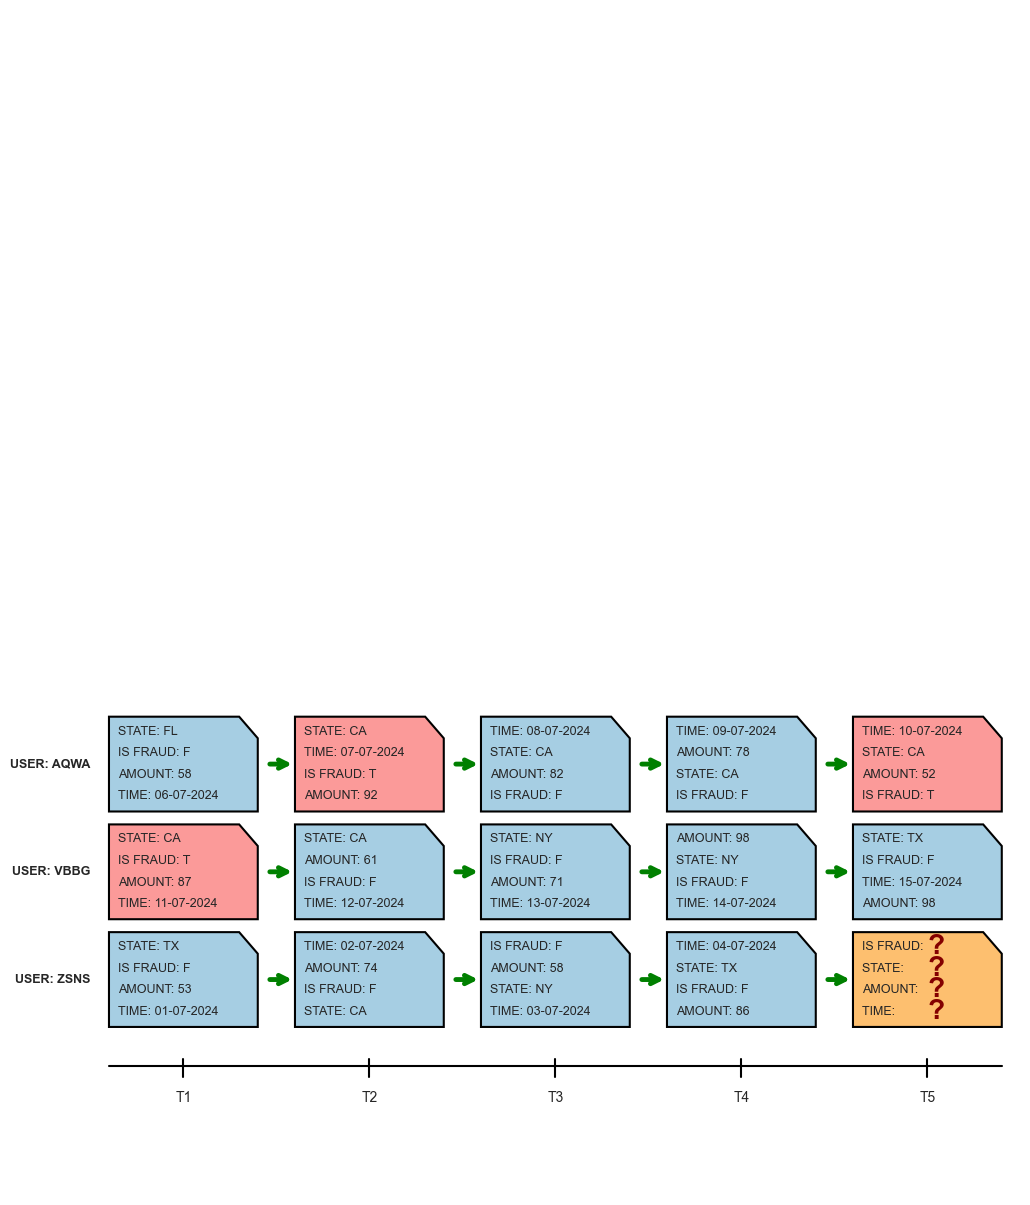

In [69]:
fig, ax = plt.subplots(figsize=(12, 15))
plt.subplots_adjust(top=0.9)

field_orders = []

# Iterate over each sequence
for user_num, y_position in enumerate(y_positions):
    user = user_list[user_num]
    subset = df_sorted[df_sorted['User'] == user]
    # Plot each transaction
    # user = subset['User'].iloc[0]  # Get the user for this row

    plt.text(0.5, y_position, f'USER: {user}', ha="right", va="center", fontsize=font_size, weight='bold')
    for i, (index, row) in enumerate(subset.iterrows()):
        x = x_positions[i]
        state = row['State']
        timestamp = row['Time']
        amount = row['Amount']
        fraud = row['Is Fraud']
        predict = fraud[0] == "?"
        field_vals = [state, timestamp, amount, fraud]
        color = "#" + color_mapping.get(fraud[0])
        
        card_box = create_custom_card(x, y_position, card_width, card_height, color)
        ax.add_patch(card_box)
        arr = np.arange(len(fields))
        if randomize_order:
            arr = np.random.permutation(arr)
            
        field_orders.append(arr)
        for i in range(len(text_locations)):
            y_loc = y_position + (text_locations[i]*text_spacing)
            field = fields[arr[i]]
            val = field_vals[arr[i]]
            # print(y_loc, field, val)
            if not predict:
                plt.text(x + text_x_start, y_loc, f'{field}: {val}', ha="left", va="center", fontsize=font_size)
            else:
                plt.text(x + text_x_start, y_loc, f'{field}: ', ha="left", va="center", fontsize=font_size)
                plt.text(x, y_loc, f'?', ha="left", va="center", fontsize=font_size2, color=other_color, weight='bold')
            

    # Add arrows to connect the transactions
    for i in range(len(x_positions) - 1):
        ax.annotate('', xy=(x_positions[i + 1] - 0.4, y_position), 
                    xytext=(x_positions[i] + 0.45, y_position),
                    size=15,
                    arrowprops=dict(facecolor='black', arrowstyle='->', lw=3.5, fc="green", ec="green"))

# Add a single timeline at the bottom of all transactions
bottom_y_position = y_positions[-1] - .9  # Adjust to place it right under the last row
plt.plot([0.6, 5.4], [bottom_y_position - 0.5, bottom_y_position - 0.5], color='black', lw=1.5)
for i, x in enumerate(x_positions):
    plt.text(x, bottom_y_position - 0.65, f'T{i + 1}', ha='center', va='center', fontsize=10)
    plt.plot([x, x], [bottom_y_position - 0.55, bottom_y_position - 0.47], color='black', lw=1.5)

# Set limits and hide axes
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0, 5.5)  # Adjusted ylim to keep rows closer to title
ax.axis('off')

# Add title
# plt.title("Event Prediction in Credit Card Transactions", fontsize=14, weight='bold')
# plt.savefig('credit_card_transactions.png', format='png', bbox_inches='tight')
plt.savefig(f'credit_card_transactions{"_" + str(randomize_order) if randomize_order else ""}.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()


[0 3 2 1]
[2 3 1 0]
2
3
1
0


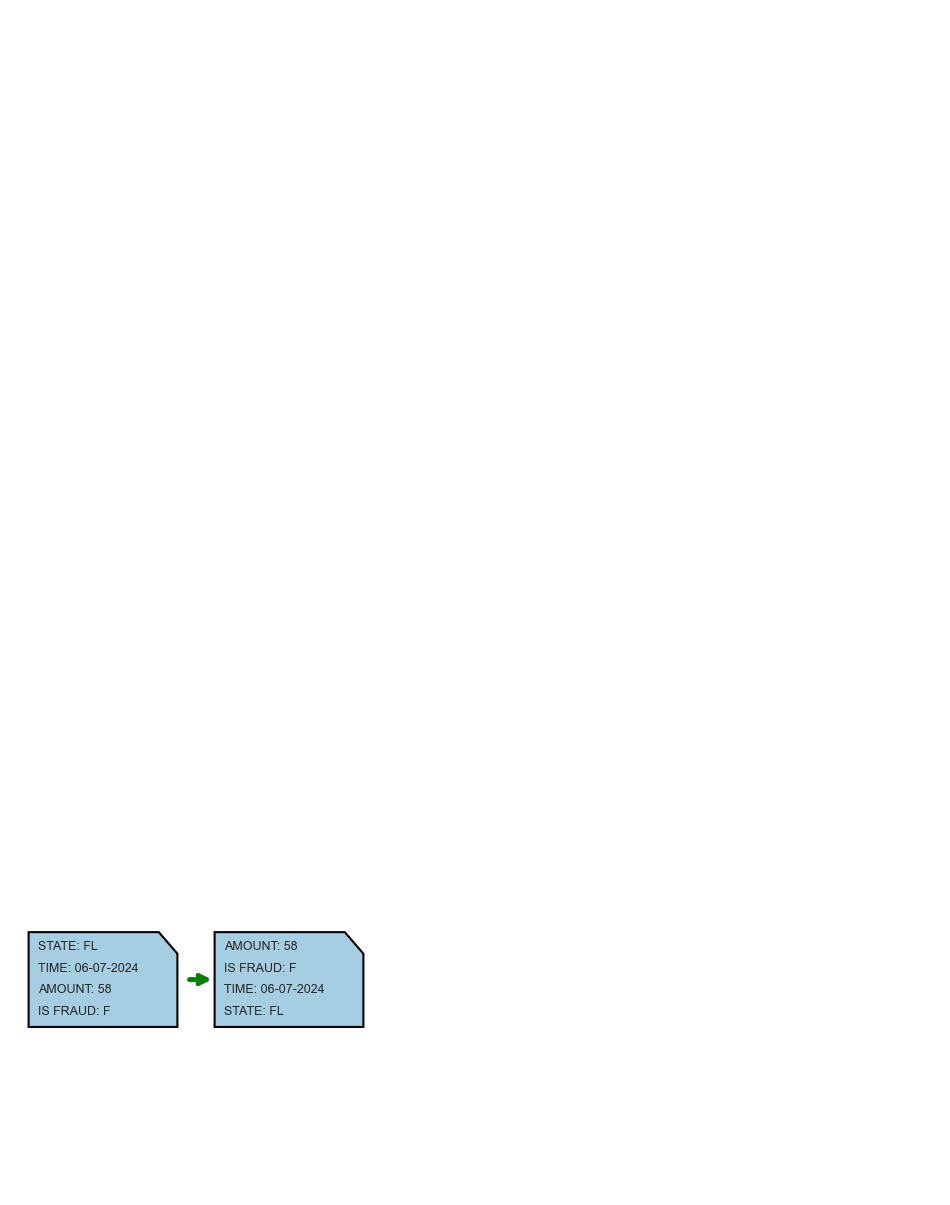

In [78]:
fig, ax = plt.subplots(figsize=(12, 15))
plt.subplots_adjust(top=0.9)

# event 1

loc = 0
x_positions = x_positions[0:2]
x = x_positions[loc]
y = 1
row = df_sorted.iloc[loc]
# x = x_positions[i]
state = row['State']
timestamp = row['Time']
amount = row['Amount']
fraud = row['Is Fraud']
predict = fraud[0] == "?"
field_vals = [state, timestamp, amount, fraud]

color = "#" + color_mapping.get(fraud[0])
card_box = create_custom_card(x, y, card_width, card_height, color)
ax.add_patch(card_box)

# plt.text(x + text_x_start, y + (1.5 * text_spacing), f'STATE: {state}', ha="left", va="center", fontsize=font_size)
# plt.text(x + text_x_start, y + (.5 * text_spacing), f'TIME: {timestamp}', ha="left", va="center", fontsize=font_size)
# plt.text(x + text_x_start, y + (-.5 * text_spacing), f'AMOUNT: ${amount}', ha="left", va="center", fontsize=font_size)
# plt.text(x + text_x_start, y + (-1.5 * text_spacing), f'IS FRAUD: {fraud}', ha="left", va="center", fontsize=font_size)
order = field_orders[loc]
for i in order:
    y_loc = y + (text_locations[i]*text_spacing)
    field = fields[i]
    val = field_vals[i]
    # print(y_loc, field, val)
    if not predict:
        plt.text(x + text_x_start, y_loc, f'{field}: {val}', ha="left", va="center", fontsize=font_size)
    else:
        plt.text(x + text_x_start, y_loc, f'{field}: ', ha="left", va="center", fontsize=font_size)
        plt.text(x, y_loc, f'?', ha="left", va="center", fontsize=font_size2, color=other_color, weight='bold')

# event 2
loc = 0
x = x_positions[1]
y = 1
row = df_sorted.iloc[loc]
# x = x_positions[i]
state = row['State']
timestamp = row['Time']
amount = row['Amount']
fraud = row['Is Fraud']
predict = fraud[0] == "?"
field_vals = [state, timestamp, amount, fraud]

color = "#" + color_mapping.get(fraud[0])
card_box = create_custom_card(x, y, card_width, card_height, color)
ax.add_patch(card_box)

# plt.text(x + text_x_start, y + (1.5 * text_spacing), f'STATE: {state}', ha="left", va="center", fontsize=font_size)
# plt.text(x + text_x_start, y + (.5 * text_spacing), f'TIME: {timestamp}', ha="left", va="center", fontsize=font_size)
# plt.text(x + text_x_start, y + (-.5 * text_spacing), f'AMOUNT: ${amount}', ha="left", va="center", fontsize=font_size)
# plt.text(x + text_x_start, y + (-1.5 * text_spacing), f'IS FRAUD: {fraud}', ha="left", va="center", fontsize=font_size)
order = field_orders[0]
print(order)
order = np.random.permutation(order)
print(order)
for ind in range(len(order)):
    i = order[ind]
    print(i)
    y_loc = y + (text_locations[ind]*text_spacing)
    field = fields[i]
    val = field_vals[i]
    # print(y_loc, field, val)
    if not predict:
        plt.text(x + text_x_start, y_loc, f'{field}: {val}', ha="left", va="center", fontsize=font_size)
    else:
        plt.text(x + text_x_start, y_loc, f'{field}: ', ha="left", va="center", fontsize=font_size)
        plt.text(x, y_loc, f'?', ha="left", va="center", fontsize=font_size2, color=other_color, weight='bold')

# Add arrows to connect the transactions
for i in range(len(x_positions) - 1):
    ax.annotate('', xy=(x_positions[i + 1] - 0.4, y), 
                xytext=(x_positions[i] + 0.45, y),
                size=15,
                arrowprops=dict(facecolor='black', arrowstyle='->', lw=3.5, fc="green", ec="green"))


# Set limits and hide axes
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0, 5.5)  # Adjusted ylim to keep rows closer to title
ax.axis('off')
plt.savefig('single_event.pdf', format='pdf', bbox_inches='tight')

In [56]:
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Apply the function to each group and create a new DataFrame
# Replace True/False with T/F
df_sorted['Is Fraud'] = df_sorted['Is Fraud'].apply(lambda x: x[0])

all_sequences = []
user_indices = []

grouped = df_sorted.groupby('User')

for name, group in grouped:
    print(name)
    print(group)
    user_sequences = split_and_format_sequences(group)
    all_sequences.extend(user_sequences)
    user_indices.extend([name] * len(user_sequences))

# Determine the number of events and features dynamically
num_features_per_event = 5  # User, Time, Asin, Verified, Rating
num_events = len(all_sequences[0]) // num_features_per_event

# Create multi-level column names
columns = []
for i in range(1, num_events // num_features_per_event + 1):
    temp_columns = []
    for j in cols:
        temp_columns.append((f'Event {i}', j))
    columns.extend(temp_columns)
    # columns.extend([(f'Event {i}', 'User'), (f'Event {i}', 'Time'), (f'Event {i}', 'Asin'), (f'Event {i}', 'Verified'), (f'Event {i}', 'Rating')])

# Adjust columns to match the actual data length
if len(all_sequences[0]) != len(columns):
    num_events = len(all_sequences[0]) // num_features_per_event
    columns = []
    for i in range(1, num_events + 1):
        # columns.extend([(f'Event {i}', 'User'), (f'Event {i}', 'Time'), (f'Event {i}', 'Asin'), (f'Event {i}', 'Verified'), (f'Event {i}', 'Rating')])
        temp_columns = []
        for j in cols:
            temp_columns.append((f'Event {i}', j))
        columns.extend(temp_columns)

# Create the multi-level index for the columns
multi_index = pd.MultiIndex.from_tuples(columns, names=['Event', 'Feature'])

# Create the reshaped DataFrame
reshaped_df = pd.DataFrame(all_sequences, columns=multi_index)

# Set the User column as the index
reshaped_df.index = user_indices
reshaped_df.index.name = 'User'

# Remove User columns from events
for i in range(1, num_events + 1):
    reshaped_df.drop((f'Event {i}', 'User'), axis=1, inplace=True)

# Select the first 5 sequences
reshaped_df_first_5_sequences = reshaped_df.head(5)

# Display the first 5 sequences
print(reshaped_df_first_5_sequences)

# Save the reshaped DataFrame as a CSV file
# reshaped_df_first_5_sequences.to_csv('formatted_sequences.csv')

# Save the reshaped DataFrame as an Excel file
file_path = 'formatted_sequences_IBM.xlsx'
reshaped_df_first_5_sequences.to_excel(file_path, index=True)

# Open the Excel file and modify cell colors
wb = load_workbook(file_path)
ws = wb.active

num_cols = (num_features_per_event - 1)

# Apply colors to the cells
for row in range(4, ws.max_row + 1):  # Starting from the second row to skip the header
    for col in range(2, ws.max_column + 1, num_cols): # go by 4s
        fraud_col = col + (num_cols - 1)
        cell = ws.cell(row=row, column=fraud_col)
        fraud_status = cell.value
        color = color_mapping.get(fraud_status, 'FFFFFFFF')
        fill = PatternFill(fgColor=color, fill_type='solid')
        # print(f"Row {row}, Column {col}: {fraud_status} -> {color}")  # Debug print
        for c in range(num_cols):
            cell = ws.cell(row=row, column=col + c)
            cell.fill = fill

# Save the modified Excel file
wb.save(file_path)

AQWA
   User State        Time Amount Is Fraud
0  AQWA    FL  06-07-2024     58        F
1  AQWA    CA  07-07-2024     92        T
2  AQWA    CA  08-07-2024     82        F
3  AQWA    CA  09-07-2024     78        F
4  AQWA    CA  10-07-2024     52        T
VBBG
   User State        Time Amount Is Fraud
5  VBBG    CA  11-07-2024     87        T
6  VBBG    CA  12-07-2024     61        F
7  VBBG    NY  13-07-2024     71        F
8  VBBG    NY  14-07-2024     98        F
9  VBBG    TX  15-07-2024     98        F
ZSNS
    User State        Time Amount Is Fraud
10  ZSNS    TX  01-07-2024     53        F
11  ZSNS    CA  02-07-2024     74        F
12  ZSNS    NY  03-07-2024     58        F
13  ZSNS    TX  04-07-2024     86        F
14  ZSNS     ?           ?      ?        ?
Event   Event 1                             Event 2                     \
Feature   State        Time Amount Is Fraud   State        Time Amount   
User                                                                     
A

In [66]:
# create_latex
prev = ""
output = ""
for i, row in df_sorted.iterrows():
    vals = row.values
    fraud = vals[-1]
    if vals[0] != prev:
        if len(output) > 0:
            output += "[EOS]\n"
        output += "[BOS],"
    prev = vals[0]
    
    # text = " ".join(vals[1:]) if vals[-1] != "?" else " \quad ".join(vals[1:])
    if not fraud == "?":
        text = (f"\\langle \\texttt{{{vals[1]}}} \\rangle,  "
                f"\\langle \\texttt{{{i}}} \\rangle,  "
                f"\\langle \\texttt{{{int(vals[3]) // 16}}} \\rangle,  "
                f"\\langle \\texttt{{{vals[4]}}}\\rangle,"
                )
    else:
        text = (f"\\langle \\texttt{{?}} \\rangle,  "
                f"\\langle \\texttt{{?}} \\rangle,  "
                f"\\langle \\texttt{{?}} \\rangle,  "
                f"\\langle \\texttt{{?}} \\rangle, "
                )
        
    boxcolor = "blue" if fraud == "F" else "red" if fraud == "T" else "orange"
    text_color_str = f"\\textcolor{{amaranth!120}}" if  fraud == '?' else ''
    template = f"\\colorbox{{{boxcolor}!100}}{{${text_color_str}{{{text}}}$}}[ROW],"
    output += template
print(output)

[BOS],\colorbox{blue!100}{${\langle \texttt{FL} \rangle,  \langle \texttt{0} \rangle,  \langle \texttt{3} \rangle,  \langle \texttt{F}\rangle,}$}[ROW],\colorbox{red!100}{${\langle \texttt{CA} \rangle,  \langle \texttt{1} \rangle,  \langle \texttt{5} \rangle,  \langle \texttt{T}\rangle,}$}[ROW],\colorbox{blue!100}{${\langle \texttt{CA} \rangle,  \langle \texttt{2} \rangle,  \langle \texttt{5} \rangle,  \langle \texttt{F}\rangle,}$}[ROW],\colorbox{blue!100}{${\langle \texttt{CA} \rangle,  \langle \texttt{3} \rangle,  \langle \texttt{4} \rangle,  \langle \texttt{F}\rangle,}$}[ROW],\colorbox{red!100}{${\langle \texttt{CA} \rangle,  \langle \texttt{4} \rangle,  \langle \texttt{3} \rangle,  \langle \texttt{T}\rangle,}$}[ROW],[EOS]
[BOS],\colorbox{red!100}{${\langle \texttt{CA} \rangle,  \langle \texttt{5} \rangle,  \langle \texttt{5} \rangle,  \langle \texttt{T}\rangle,}$}[ROW],\colorbox{blue!100}{${\langle \texttt{CA} \rangle,  \langle \texttt{6} \rangle,  \langle \texttt{3} \rangle,  \lang

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load and clean the data
raw_data_path = '/Users/alex/Documents/School/Maryland/Research/event_prediction/data/submit2/testing.csv'

ind_cols = ["eval experiment folder name", "eval randomize order",	"eval mask all pct", "eval mask each pct", "train randomize order", "train mask all pct", "train mask each pct"]
# import pandas as pd

metrics = ['auc', 'auc last', 'auc consolidated', 'auc last consolidated']
# agg_map = {
#     'auc'
# }

# Step 1: Load the provided raw data with specified header levels
# raw_data_path = 'path/to/your/testing.csv'
raw_df = pd.read_csv(raw_data_path, header=[0], index_col=[0])

# Display the first few rows to inspect the structure
print("Raw Data:")
print(raw_df.head())


Raw Data:
   batches   rows  accuracy       auc  f1 micro  f1 macro  f1 weighted  \
0      211  94316  0.654322  0.703377  0.654322  0.258995     0.558723   
1      210  92843  0.656011  0.704922  0.656011  0.255756     0.556535   
2      212  94337  0.656370  0.701274  0.656370  0.261843     0.562287   
3      210  92966  0.652712  0.700114  0.652712  0.259127     0.558165   
4      214  95765  0.658476  0.707567  0.658476  0.267294     0.566514   

  accuracy consolidated auc consolidated f1 micro consolidated  ... numGPUs  \
0              0.820985         0.727411              0.820985  ...       1   
1              0.819674         0.730636              0.819674  ...       1   
2              0.818237         0.722663              0.818237  ...       1   
3              0.819192         0.723446              0.819192  ...       1   
4              0.817177          0.73162              0.817177  ...       1   

        kWh                               exp  fata-trans  TabBERT  Un

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '/Users/alex/Documents/School/Maryland/Research/event_prediction/data/submit2/testing.csv'
data = pd.read_csv(file_path)
bad_training_runs = ["final_ibm_fraud_transaction_base-2024-07-07-02-01"]
data = data[~data["train saved name"].isin(bad_training_runs)]

print(data[data["exp"]=="EVAL_pretrain_ibm"])
# Columns for indexing and aggregation
ind_cols = [
    "eval experiment folder name", "eval randomize order", "eval mask all pct", 
    "eval mask each pct", "train randomize order", "train mask all pct", 
    "train mask each pct"
]
agg_cols = ['auc', 'auc last', 'auc consolidated', 'auc last consolidated']

# Renaming columns to match the required index columns
data.columns = data.columns.str.strip()
# data = data.rename(columns={"exp": "eval experiment folder name"})

# Handling missing values by filling them with NaN (if necessary)
data[agg_cols] = data[agg_cols].apply(pd.to_numeric, errors='coerce')
# Grouping by the index columns and aggregating the mean, std, and count
grouped_data = data.groupby(ind_cols)[agg_cols].agg(['mean', 'std', 'count']).reset_index()

# Removing trailing underscores from column names for consistency
grouped_data.columns = ['_'.join(col).rstrip('_') for col in grouped_data.columns]

# Creating a new column for the desired metric based on the experiment
grouped_data['desired_metric_mean'] = grouped_data.apply(
    lambda row: row['auc last consolidated_mean'] if 'amazon' in row['eval experiment folder name'] else row['auc last_mean'],
    axis=1
)

grouped_data['desired_metric_std'] = grouped_data.apply(
    lambda row: row['auc last consolidated_std'] if 'amazon' in row['eval experiment folder name'] else row['auc last_std'],
    axis=1
)


# Filtering the data as specified before
filtered_data = grouped_data[
    (grouped_data["train mask all pct"] == 0.0) &
    (grouped_data["train mask each pct"] == 0.0) &
    (grouped_data["eval mask all pct"] == 0.0) &
    (grouped_data["eval mask each pct"] == 0.0) &
    (grouped_data["eval randomize order"] == True)
]

# Prepare the data for plotting
plot_data = filtered_data[['eval experiment folder name', 'train randomize order', 'desired_metric_mean', 'desired_metric_std']]

plot_data['Method'] = plot_data['train randomize order'].map({True: 'STEP: Random ordering during training=True', False: 'STEP: Random ordering during training=False'})
plot_data = plot_data.rename(columns={'desired_metric_mean': 'Value', 'desired_metric_std': 'Std'})

# Mapping the experiment names for better readability
plot_data['eval experiment folder name'] = plot_data['eval experiment folder name'].map({
    'EVAL_pretrain_amazon_electronics': 'Amazon Electronics',
    'EVAL_pretrain_amazon_movies': 'Amazon Movies',
    'EVAL_pretrain_ibm': 'Fraud Detection'
})
# Combine the benchmark data with the plot data
plot_data = plot_data.rename(columns={'eval experiment folder name': 'Dataset'})


     Unnamed: 0  batches    rows  accuracy       auc  f1 micro  f1 macro  \
360         360      691  441658  0.999425  0.987155  0.999425  0.894724   
361         361      702  448982  0.999572  0.988207  0.999572  0.888782   
362         362      609  389497  0.999338  0.979779  0.999338  0.871604   
363         363      885  565933  0.999228  0.977206  0.999228  0.822597   
364         364      869  555938  0.999394  0.981079  0.999394  0.789486   
..          ...      ...     ...       ...       ...       ...       ...   
541         541      610  389742  0.999731  0.990005  0.999731  0.953349   
542         542      788  503939  0.999546  0.979036  0.999546  0.831751   
543         543      886  566541  0.999522  0.986145  0.999522  0.867685   
544         544      636  406262  0.999313  0.992599  0.999313  0.901381   
545         545      630  402967  0.999479  0.965726  0.999479  0.866958   

     f1 weighted  accuracy consolidated  auc consolidated  ...  accuracy Year  \
360   

/var/folders/zz/wbklkpzn7ssgpvgbh7ptnxw00000gn/T/ipykernel_58851/2095127531.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Method'] = plot_data['train randomize order'].map({True: 'STEP: Random ordering during training=True', False: 'STEP: Random ordering during training=False'})


In [33]:
benchmarks = {
    "Fata-Trans":
        {
            "Fraud Detection": 0.9992,
            "Amazon Electronics": 0.7206,
            "Amazon Movies": 0.8057,
        },
    "TabBERT":
        {
            "Fraud Detection": 0.9985,
            "Amazon Electronics": 0.7098,
            "Amazon Movies": 0.7964,
        },
    "UniTTab":
        {
            "Fraud Detection": 0.987,
        }
}
# Convert the benchmark dictionary to a DataFrame
benchmark_data = []
for method, datasets in benchmarks.items():
    for dataset, value in datasets.items():
        benchmark_data.append([method, dataset, value, 0])  # Adding 0 for std deviation as benchmarks don't have it

benchmark_df = pd.DataFrame(benchmark_data, columns=['Method', 'Dataset', 'Value', 'Std'])


               Dataset                                       Method     Value  \
18  Amazon Electronics  STEP: Random ordering during training=False  0.602048   
21  Amazon Electronics   STEP: Random ordering during training=True  0.743897   
54       Amazon Movies  STEP: Random ordering during training=False  0.606851   
57       Amazon Movies   STEP: Random ordering during training=True  0.821490   
90     Fraud Detection  STEP: Random ordering during training=False  0.597460   
93     Fraud Detection   STEP: Random ordering during training=True  0.971505   
0      Fraud Detection                                   Fata-Trans  0.999200   
1   Amazon Electronics                                   Fata-Trans  0.720600   
2        Amazon Movies                                   Fata-Trans  0.805700   
3      Fraud Detection                                      TabBERT  0.998500   
4   Amazon Electronics                                      TabBERT  0.709800   
5        Amazon Movies      

/var/folders/zz/wbklkpzn7ssgpvgbh7ptnxw00000gn/T/ipykernel_58851/2798756345.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Dataset', y='Value', hue='Method', data=combined_data, ci=None, capsize=0.1)


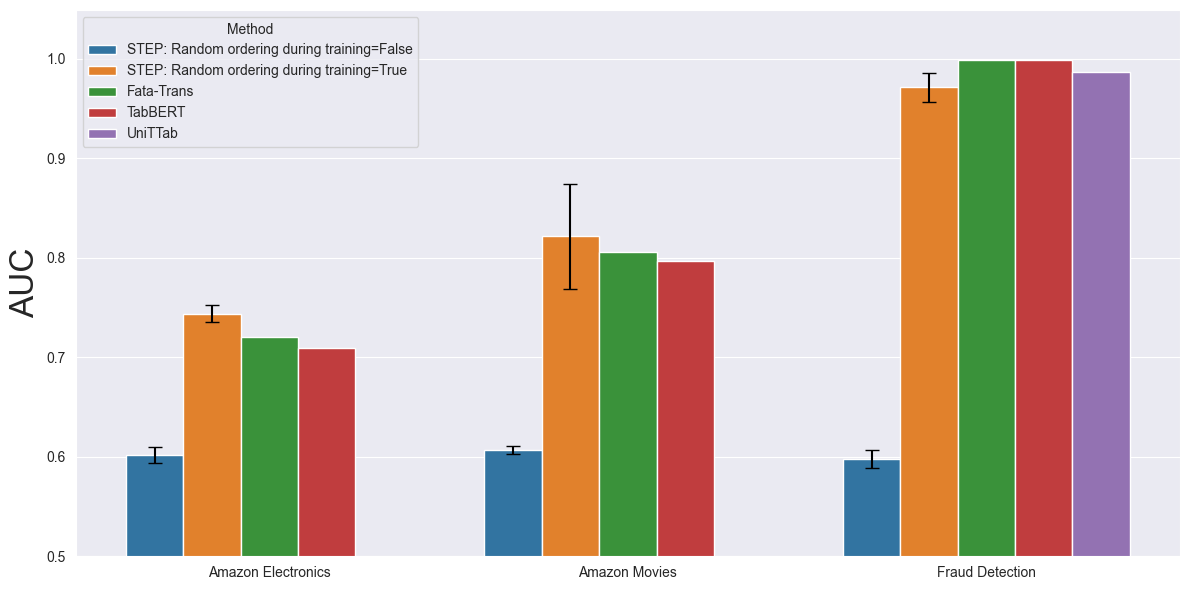

In [34]:
combined_data = pd.concat([plot_data[['Dataset', 'Method', 'Value', 'Std']], benchmark_df])
print(combined_data)
# Plotting the bar chart with error bars
plt.figure(figsize=(12, 6))

# Using seaborn to plot the bar chart
ax = sns.barplot(x='Dataset', y='Value', hue='Method', data=combined_data, ci=None, capsize=0.1)

# Adding the error bars manually for 'Train Randomize Order'
for i, (index, row) in enumerate(plot_data.iterrows()):
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    std = row['Std']
    ax.errorbar(x, y, yerr=std, fmt='none', c='black', capsize=5)

ax.set_ylim(ymin = .5)

# Adding labels and title
plt.xlabel('', fontsize=24)
plt.ylabel('AUC', fontsize=24)
# plt.title('Columns Randomized at Evaluation Time', fontsize=36)
plt.legend(title='Method')


# Displaying the plot
plt.tight_layout()
plt.savefig('randomized_eval.pdf', format="pdf")

plt.show()

In [35]:
# for base chart:

# Filtering the data as specified before
filtered_data = grouped_data[
    (grouped_data["train mask all pct"] == 0.0) &
    (grouped_data["train mask each pct"] == 0.0) &
    (grouped_data["eval mask all pct"] == 0.0) &
    (grouped_data["eval mask each pct"] == 0.0) &
    (grouped_data["train randomize order"] == False) & 
    (grouped_data["eval randomize order"] == False)
]
# Prepare the data for plotting
plot_data = filtered_data[['eval experiment folder name', 'train randomize order', 'desired_metric_mean', 'desired_metric_std']]

# CHANGE THIS
# plot_data['Method'] = plot_data['train randomize order'].map({True: 'Train Randomize Order = True', False: 'Train Randomize Order = False'})
plot_data['Method'] = "STEP"
plot_data = plot_data.rename(columns={'desired_metric_mean': 'Value', 'desired_metric_std': 'Std'})

# Mapping the experiment names for better readability
plot_data['eval experiment folder name'] = plot_data['eval experiment folder name'].map({
    'EVAL_pretrain_amazon_electronics': 'Amazon Electronics',
    'EVAL_pretrain_amazon_movies': 'Amazon Movies',
    'EVAL_pretrain_ibm': 'Fraud Detection'
})
# Combine the benchmark data with the plot data
plot_data = plot_data.rename(columns={'eval experiment folder name': 'Dataset'})


/var/folders/zz/wbklkpzn7ssgpvgbh7ptnxw00000gn/T/ipykernel_58851/413318619.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Method'] = "STEP"


               Dataset      Method     Value       Std
0   Amazon Electronics        STEP  0.771330  0.007280
36       Amazon Movies        STEP  0.853266  0.005606
72     Fraud Detection        STEP  0.997779  0.002364
0      Fraud Detection  Fata-Trans  0.999200  0.000000
1   Amazon Electronics  Fata-Trans  0.720600  0.000000
2        Amazon Movies  Fata-Trans  0.805700  0.000000
3      Fraud Detection     TabBERT  0.998500  0.000000
4   Amazon Electronics     TabBERT  0.709800  0.000000
5        Amazon Movies     TabBERT  0.796400  0.000000
6      Fraud Detection     UniTTab  0.987000  0.000000


/var/folders/zz/wbklkpzn7ssgpvgbh7ptnxw00000gn/T/ipykernel_58851/1147138548.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Dataset', y='Value', hue='Method', data=combined_data, ci=None, capsize=0.1)


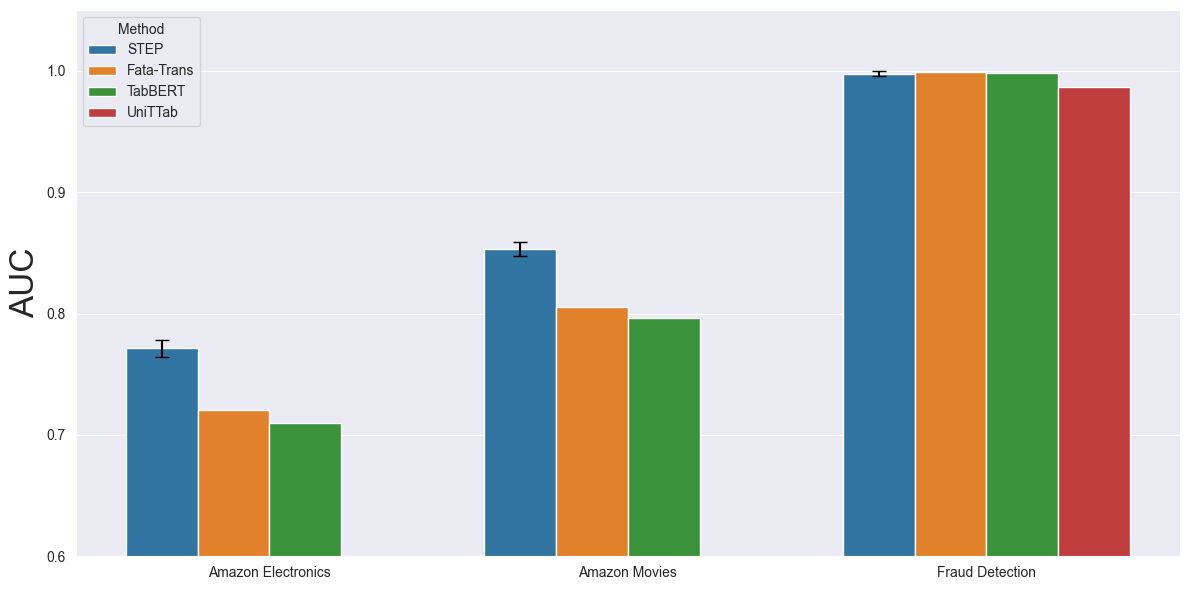

In [36]:
combined_data = pd.concat([plot_data[['Dataset', 'Method', 'Value', 'Std']], benchmark_df])
print(combined_data)
# Plotting the bar chart with error bars
plt.figure(figsize=(12, 6))

# Using seaborn to plot the bar chart
ax = sns.barplot(x='Dataset', y='Value', hue='Method', data=combined_data, ci=None, capsize=0.1)

# Adding the error bars manually for 'Train Randomize Order'
for i, (index, row) in enumerate(plot_data.iterrows()):
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    std = row['Std']
    ax.errorbar(x, y, yerr=std, fmt='none', c='black', capsize=5)

ax.set_ylim(ymin = .6)

# Adding labels and title
plt.xlabel('', fontsize=24)
plt.ylabel('AUC', fontsize=24)
# plt.title('Baseline Comparison', fontsize=36)
plt.legend(title='Method')


# Displaying the plot
plt.tight_layout()
plt.savefig('baseline_comp.pdf', format="pdf")
plt.show()